In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from palettable.tableau import ColorBlind_10
import copy
mpl.rcParams['figure.dpi']= 200
%config InlineBackend.figure_format = 'svg'
# plt.rcParams['font.size'] = 15
# mpl.rcParams['axes.linewidth'] = 2

In [7]:
amu_ry = 1822.888486209/2
RY_TO_THz = 3289.8419603555
RY_TO_meV = 13605.6622851
RY_TO_CMM = RY_TO_THz * 33.35641
THz_TO_CMM = 33.35641

def xk_init(nx,ny,nz):
    xk = np.zeros([nx*ny*nz,3])
    for i in range(nx):
        thisx = i/nx
        if thisx >= 0.5:
            thisx -= 1.0
        for j in range(ny):
            thisy = j/ny
            if thisy >= 0.5:
                thisy -= 1.0
            for k in range(nz):
                thisz = k/nz
                if thisz >= 0.5:
                    thisz -= 1.0
                xk[i*ny*nz+j*nz+k] = [thisx,thisy,thisz]
    return xk    

def xq_init(nx,ny,nz):
#     return xk_init(nx,ny,nz)
    xq = np.zeros([nx*ny*nz,3])
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                xq[i*ny*nz+j*nz+k] = [i/nx,j/ny,k/nz]
    return xq

def process_PHonon_fildyn(fname):
    freqs = []
    with open(fname) as f:
        line = f.readline()
        while line != '':
            if 'freq' in line:
                freqs.append(float(line[19:35]))
            line = f.readline()
    return np.array(freqs)

## 3x3x3

In [8]:
nx = 3
ny = 3
nz = 3
nq = nx*ny*nz
xq = xq_init(nx,ny,nz)
path = []
G_point = np.array([0.0,0.0,0.0])
X_point = np.array([0.0,0.5,0.5])
K_point = np.array([3.0/8,3.0/4,3.0/8])
L_point = np.array([0.5,0.5,0.5])
for frac in np.arange(0,1,0.02):
    path.append((1.0-frac)*G_point+frac*X_point)
for frac in np.arange(0,1,0.02):
    path.append((1.0-frac)*X_point+frac*K_point)
for frac in np.arange(0,1,0.02):
    path.append((1.0-frac)*K_point+frac*G_point)
for frac in np.arange(0,1,0.02):
    path.append((1.0-frac)*G_point+frac*L_point)
path = np.array(path)
n_path = len(path)
# print(path)
# print(len(np.arange(0,1,0.02)))
# print(n_path)

In [9]:
fconsts = np.zeros([nq,6,6],dtype=np.complex)
for iq in range(nq):
    fname = "60Ry/c.welph.save.pdep200/dynmat_iq%05d.csv"%(iq+1)
    df = pd.read_csv(fname,names=['iq','imode','re','im'])
    fconsts[iq] = (df['re'].values+np.complex(0,1)*df['im'].values).reshape(6,6)
    fconsts[iq] = (fconsts[iq] + np.conj(np.transpose(fconsts[iq])))/2

w_on_grid = np.zeros([nq,6])
for iq in range(nq):
    w2 = np.linalg.eigvalsh(fconsts[iq])
    w_on_grid[iq] = np.sqrt(np.abs(w2))*RY_TO_THz

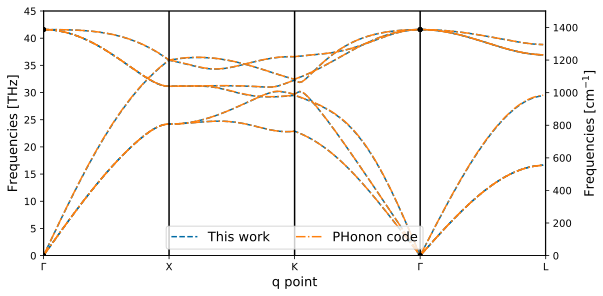

After interpolation, mean absolute difference is :   0.63 cm^-1
After interpolation, max  absolute difference is :   3.42 cm^-1


In [10]:
fname = "60Ry/c_qe.freq"
ref_phonons = []
with open(fname,"r") as f:
    line = f.readline()
    for iq in range(n_path):
        line = f.readline()
        line = f.readline()
#         print(line)
        ref_phonons.append([float(x) for x in line.split()])
ref_phonons = np.array(ref_phonons)/THz_TO_CMM

fname = "60Ry/c_welph.freq"
phonons = []
with open(fname,"r") as f:
    line = f.readline()
    for iq in range(n_path):
        line = f.readline()
        line = f.readline()
#         print(line)
        phonons.append([float(x) for x in line.split()])
phonons = np.array(phonons)/THz_TO_CMM

fig = plt.figure(figsize=(9,4.5))
ax1 = fig.gca()
for imode in range(6):
    if imode == 0:
        plt.plot(range(len(phonons[:,imode])),phonons[:,imode],linestyle='dashed',c=ColorBlind_10.hex_colors[0],label="This work")
    else:
        plt.plot(range(len(phonons[:,imode])),phonons[:,imode],linestyle='dashed',c=ColorBlind_10.hex_colors[0])    
for imode in range(6):
    if imode == 0:
        plt.plot(range(len(ref_phonons[:,imode])),ref_phonons[:,imode],linestyle='dashdot',c=ColorBlind_10.hex_colors[1],label="PHonon code")
    else:
        plt.plot(range(len(ref_phonons[:,imode])),ref_phonons[:,imode],linestyle='dashdot',c=ColorBlind_10.hex_colors[1])
plt.plot([0,0],[0,45],'k')
plt.plot([50,50],[0,45],'k')
plt.plot([100,100],[0,45],'k')
plt.plot([150,150],[0,45],'k')
plt.plot([200,200],[0,45],'k')

tmpx = []
tmpy = []
for iq in range(nq):
    for iqq in range(n_path):
        if np.linalg.norm(xq[iq]-path[iqq]) < 1e-6:
            for imode in range(6):
                tmpx.append(iqq)
                tmpy.append(w_on_grid[iq][imode])

plt.plot(tmpx,tmpy,'o',c='k',markersize=4,)

plt.xlim([0,200])
plt.ylim([0,45])
plt.xlabel("q point",fontsize=13)
plt.ylabel('Frequencies [THz]',fontsize=13)
plt.xticks([0,50,100,150,200],[r"$\Gamma$","X","K",r"$\Gamma$","L"])
plt.legend(ncol=3,loc="lower center",fontsize=13)
ax2 = ax1.twinx()
[ymin,ymax] = ax1.get_ylim()
plt.ylim([ymin*THz_TO_CMM,ymax*THz_TO_CMM])
plt.ylabel(r"Frequencies [$\mathrm{cm^{-1}}$]",fontsize=13)
plt.show()
fig.savefig("Diamond_phonon_dispersion_60Ry.png",dpi=200,bbox_inches="tight")

print(r"After interpolation, mean absolute difference is : %6.2f cm^-1"%(np.mean(abs(phonons-ref_phonons))*THz_TO_CMM))
print(r"After interpolation, max  absolute difference is : %6.2f cm^-1"%(np.max(abs(phonons-ref_phonons))*THz_TO_CMM))